In [1]:
from spikee.utils import evaluate
from spikee.utils.batcher import batch_provider
from spikee.utils import conv
from spikee.models.SpikE import SpikE_Scorer_AS as scorer
from spikee.training import train
import matplotlib.pyplot as plt
import time
import numpy as np
import torch

**Some functions for the evaluation**

In [2]:
def get_names(variables, ent2id):
    varse = []
    for i in ent2id.keys():
        for vv in variables:
            if vv in i:
                varse.append(i)
    return varse

def get_dataranking(model):
    subj = 'opc#app1'
    pred = 'opc#Read'

    ent2id = conv.get_ent2id(datapath)
    rel2id = conv.get_rel2id(datapath)

    variables_train = ['UAVariable-voltageL2', 'UAVariable-voltageL1', 'UAVariable-curr']
    variables_pos = ['UAVariable-active', 'aml#UAVariable-voltageL3']
    variables_mid = ['UAVariable-proximity', 'UAVariable-drive', 'UAVariable-signal', 'UAVariable-pt100', 'UAVariable-ultrasonic']
    variables_neg = ['UAVariable-Device', 'UAVariable-Op', 'UAVariable-Ma', 'UAVariable-S', 'UAVariable-Rev', 'UAVariable-Eng', 'UAVariable-6', 'UAVariable-H',
                'UAVariable-Mo', 'UAVariable-Or']

    datasets = []
    for var in [variables_train, variables_pos, variables_mid, variables_neg]:
        datasets.append(get_names(var, ent2id))

    rankings = [[] for i in range(len(datasets))]            
    for i in range(len(datasets)):
        for j in datasets[i]:
            rankings[i].append(evaluate.score_triple(rel2id, ent2id, model, subj, pred, j).detach().numpy()[0])
        rankings[i] = np.array(rankings[i])
        
    return datasets, rankings


**Load and preprocess the data (mostly remove opc sessions and old data events)**

In [3]:
datapath = '../data/Industrial_Automation'
train_data, valid_data, num_nodes, num_predicates = conv.load_data(datapath)

# merge train and valid data set
merged_data = []
for [s,p,o] in train_data:
    merged_data.append([s,p,o])
for [s,p,o] in valid_data:
    merged_data.append([s,p,o])
train_data = np.array(merged_data)

ent2id = conv.get_ent2id(datapath)
rel2id = conv.get_rel2id(datapath)
id2ent = conv.get_id2ent(datapath)
id2rel = conv.get_id2rel(datapath)

In [4]:
# remove session nodes for new data read representation
sessions = []
for key in ent2id.keys():
    if 'ns_' in key:
        sessions.append(key)

new_data = []
for [s,p,o] in train_data:
    if id2ent[s] in sessions or id2ent[o] in sessions:
        continue
    else:
        new_data.append([s,p,o])
train_data = np.array(new_data)      

In [5]:
# there are a few erronous triples in the data, clean them up first
erronous_triples = []

predid = rel2id['aml#hasUAVariablePLCtag']
for k in train_data[train_data[:, 1] == predid]:
    if id2ent[k[0]].split('-')[-1] != id2ent[k[2]].split('-')[-1]:
        erronous_triples.append(k[2])
for k in valid_data[valid_data[:, 1] == predid]:
    if id2ent[k[0]].split('-')[-1] != id2ent[k[2]].split('-')[-1]:
        erronous_triples.append(k[2])
        
new_data = []
for [s,p,o] in train_data:
    if o in erronous_triples and p == predid:
        continue
    else:
        new_data.append([s,p,o])
train_data = new_data

**Add apps and data events**

In [6]:
np.random.seed(12381347)

# read relation
pred = rel2id['opc#Read']

# app1 reads the following data
msubj = ent2id['opc#app1']
mobjsnew = [ent2id['aml#UAVariable-voltageL1-N'],ent2id['aml#UAVariable-voltageL2-N'],ent2id['aml#UAVariable-currentL1'], ent2id['aml#UAVariable-currentL2'], ent2id['aml#UAVariable-currentL3']]
mevents = np.random.randint(10,40,size=len(mobjsnew))

# app2 reads the following data
fsubj = ent2id['opc#app2']
fobjsnew = [ent2id['aml#UAVariable-signalGreen'], ent2id['aml#UAVariable-signalYellow']]
fevents = np.random.randint(20,90,size=len(fobjsnew))

# apps initiated from different edge hosts
train_data.append([msubj, rel2id['opc#initiatedFrom'], ent2id['zeek#192.168.0.17']])
train_data.append([fsubj, rel2id['opc#initiatedFrom'], ent2id['zeek#192.168.0.18']])

# add app1 read events to data
for i in range(len(mobjsnew)):
    for k in range(mevents[i]):
        train_data.append([msubj, pred, mobjsnew[i]])

# add app2 read events to data
for i in range(len(fobjsnew)):
    for k in range(fevents[i]):
        train_data.append([fsubj, pred, fobjsnew[i]])
train_data = np.array(train_data)

**Create some negative examples as a cross-check during training**

In [7]:
neg_data = []

np.random.seed(1234)
for i,j,k in train_data:
    neg_data.append([np.random.randint(num_nodes), j, k])
    neg_data.append([i,j,np.random.randint(num_nodes)])
    
neg_data = np.array(neg_data)

**Train model**

In [8]:
params = {
    'dim': 20,
    'input_size': 40,
    'tau': 0.5,
    'batchsize': 50,
    'delta': 0.01,
    'lr': 1.0,
    'L2': 0.,
    'steps': 6001,
    'neg_samples': 2,
    'maxspan': 2,
}
seed = 67815399

In [9]:
batcher = batch_provider(train_data, params['batchsize'], params['neg_samples'], seed)
model = scorer(num_nodes, num_predicates, params['dim'], params['input_size'], params['tau'], params['maxspan'], seed)
optimizer = torch.optim.Adagrad([model.entities.weights.weight, model.predicates.weight], lr=params['lr'], weight_decay = params['L2'])
train(optimizer, batcher, model,params['delta'], params['steps'], data = [train_data, valid_data, neg_data])

SpikE 0: ETA 0.0min ~~~~~~~~~ train: -20.870195388793945 __valid: -21.003551483154297 __neg: -20.38400650024414
SpikE 100: ETA 22.04min ~~~~~~~~~ train: -5.689103126525879 __valid: -6.423304557800293 __neg: -8.073651313781738
SpikE 200: ETA 21.52min ~~~~~~~~~ train: -4.374027252197266 __valid: -4.949889183044434 __neg: -6.474492073059082
SpikE 300: ETA 21.08min ~~~~~~~~~ train: -3.494586706161499 __valid: -3.9781076908111572 __neg: -5.477099895477295
SpikE 400: ETA 20.61min ~~~~~~~~~ train: -3.0157907009124756 __valid: -3.398263931274414 __neg: -4.89213752746582
SpikE 500: ETA 20.18min ~~~~~~~~~ train: -2.617520570755005 __valid: -2.9559035301208496 __neg: -4.4225945472717285
SpikE 600: ETA 19.75min ~~~~~~~~~ train: -2.3321921825408936 __valid: -2.646801233291626 __neg: -4.129191875457764
SpikE 700: ETA 19.34min ~~~~~~~~~ train: -2.110208511352539 __valid: -2.4140212535858154 __neg: -3.902719497680664
SpikE 800: ETA 18.93min ~~~~~~~~~ train: -1.9535248279571533 __valid: -2.229219913482

**Evaluate how various data events are ranked by the model**

**Create dataevents to check, separated into four categories**
1) seen during training

2) data variables that share structure with variables accessed during training + hang from the same PLC

3) data variables that hang from the same PLC

4) almost no relation with variables accessed during training

In [10]:
subj = 'opc#app1'
pred = 'opc#Read'

ent2id = conv.get_ent2id(datapath)
rel2id = conv.get_rel2id(datapath)

variables_train = ['UAVariable-voltageL2', 'UAVariable-voltageL1', 'UAVariable-curr']
variables_pos = ['UAVariable-active', 'aml#UAVariable-voltageL3']
variables_mid = ['UAVariable-proximity', 'UAVariable-drive', 'UAVariable-signal', 'UAVariable-pt100', 'UAVariable-ultrasonic']
variables_neg = ['UAVariable-Device', 'UAVariable-Op', 'UAVariable-Ma', 'UAVariable-S', 'UAVariable-Rev', 'UAVariable-Eng', 'UAVariable-6', 'UAVariable-H',
                'UAVariable-Mo', 'UAVariable-Or']

datasets = []
for var in [variables_train, variables_pos, variables_mid, variables_neg]:
    datasets.append(get_names(var, ent2id))
    
variables = []
for vv in datasets:
    variables += vv

In [11]:
v1, r1 = get_dataranking(model)
variables = dict(zip(variables, np.arange(len(variables))))

/home/dodo/SpikE_ph/spikee/models/neurons/nLIF.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_embs = torch.tensor(s_embs).long()
/home/dodo/SpikE_ph/spikee/models/neurons/nLIF.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  o_embs = torch.tensor(o_embs).long()
/home/dodo/SpikE_ph/spikee/models/SpikE.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_emb = self.predicates(torch.tensor(pred).long())


**Scoring of data events, where a low score means the event is ranked as more plausible by the trained network. Plausibility in descending order: green (star), yellow (diamond), orange (square), red (circle).** 

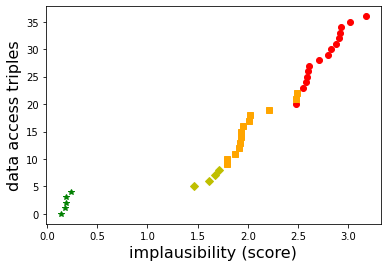

In [19]:
colors = ['g', 'y', 'orange', 'r']
markers = ['*', 'D', 's', 'o']

scores = []
labels = []
for k in range(len(v1)):
    for i in range(len(v1[k])):
        labels.append(k)
        scores.append(-r1[k][i])
order = np.argsort(scores)
scores = np.array(scores)[order]
labels = np.array(labels)[order]

ypos = 0
for k in range(len(scores)):
    plt.plot(scores[k], [ypos], color=colors[labels[k]], marker=markers[labels[k]])
    ypos += 1

plt.xlabel('implausibility (score)', fontsize = 16)
_ = plt.ylabel('data access triples', fontsize = 16)